In [1]:
from __future__ import division
import datetime as dt
from collections import OrderedDict
import sys, os
import dateutil.relativedelta as rd

import pandas as pd
import numpy as np

gtfstk_dir = '../../gtfstk/'
sys.path.append(gtfstk_dir)
import gtfstk as gt

data_dir = gtfstk_dir + 'data/'

%load_ext autoreload
%autoreload 2
# Comment out the next line if matplotlib is not installed
%matplotlib inline  


In [2]:
# Import a feed
feed = gt.read_gtfs(data_dir + 'cairns_gtfs.zip')

# Set study date
date = gt.compute_busiest_date(feed, gt.get_first_week(feed))
date

'20140530'

In [3]:
gt.assess(feed)

has_shape_dist_traveled                                 False
num_missing_dists                                       37790
frac_missing_dists                                          1
has_direction_id                                         True
num_missing_directions                                      0
frac_missing_directions                                     0
num_trips_missing_shapes                                    0
frac_trips_missing_shapes                                   0
num_missing_departure_times                                65
frac_missing_departure_times                       0.00172003
num_missing_first_departure_times                           0
frac_missing_first_departure_times                          0
assessment                            probably a fixable feed
dtype: object

In [4]:
# Compute trips stats
trips_stats = gt.compute_trips_stats(feed)
trips_stats.head().T

,703,0,704,705,706
trip_id,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Weekday-00-4165879,CNS2014-CNS_MUL-Weekday-00-4165880,CNS2014-CNS_MUL-Weekday-00-4165881
route_id,110-423,110-423,110-423,110-423,110-423
route_short_name,110,110,110,110,110
route_type,3,3,3,3,3
direction_id,0,0,0,0,0
shape_id,1100023,1100023,1100023,1100023,1100023
num_stops,35,35,35,35,35
start_time,05:50:00,06:16:00,06:20:00,06:50:00,07:15:00
end_time,06:50:00,07:10:00,07:20:00,07:50:00,08:20:00
start_stop_id,750337,750337,750337,750337,750337


In [5]:
# Add shape distance traveled field to stop times
feed.stop_times = gt.add_dist_to_stop_times(feed, trips_stats)
feed.stop_times.head().T

,17709,17710,17711,17712,17713
trip_id,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Saturday-00-4165937,CNS2014-CNS_MUL-Saturday-00-4165937
arrival_time,06:16:00,06:16:00,06:18:00,06:20:00,06:21:00
departure_time,06:16:00,06:16:00,06:18:00,06:20:00,06:21:00
stop_id,750337,750000,750001,750002,750003
stop_sequence,1,2,3,4,5
pickup_type,0,0,0,0,0
drop_off_type,0,0,0,0,0
shape_dist_traveled,0,0.46864,1.19038,2.15478,2.619


In [6]:
# Get trips
gt.get_trips(feed, date).head()

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165878,The Pier Cairns Terminus,0,NaN,1100023
1,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165879,The Pier Cairns Terminus,0,NaN,1100023
2,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165880,The Pier Cairns Terminus,0,NaN,1100023
3,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165881,The Pier Cairns Terminus,0,NaN,1100023
4,110-423,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00-4165882,The Pier Cairns Terminus,0,NaN,1100023


In [7]:
# Compute stops stats for that date
stops_stats = gt.compute_stops_stats(feed, date, split_directions=True)
stops_stats.head()

,stop_id,direction_id,num_routes,num_trips,start_time,end_time,max_headway,min_headway,mean_headway
0,750000,0,2,34,05:50:00,27:50:00,34,23,29.863636
1,750001,0,2,34,05:52:00,27:51:00,35,23,29.909091
2,750002,0,2,34,05:54:00,27:52:00,35,23,29.909091
3,750003,0,2,34,05:55:00,27:52:00,35,23,29.909091
4,750004,0,2,34,05:57:00,27:53:00,34,23,29.863636


In [8]:
# Compute stops time series for that date
sts = gt.compute_stops_time_series(feed, date, split_directions=True)
sts = gt.downsample(sts, freq='6H')
sts.head().T

2014-05-30 00:00:00  2014-05-30 06:00:00  \
indicator stop_id direction_id                                             
num_trips 750000  0                               5                   12   
          750001  0                               5                   12   
          750002  0                               5                   12   
          750003  0                               5                   12   
          750004  0                               5                   12   
          750005  0                               5                   12   
          750006  0                               4                   12   
          750007  0                               4                   12   
          750008  0                               4                   12   
          750009  0                               4                   12   
          750010  0                               4                   12   
          750011  0                               4                   12   
          750012  0                               4                   12   
          750013  0                               4                   12   
          750014  0                               4                   12   
          750015  0                               4                   24   
          750016  0                               4                   12   
          750017  0                               4                   12   
          750018  0                               4                   12   
                  1                               6                    8   
          750019  1                               6                    8   
          750020  0                               4                   12   
          750021  0                               4                   12   
          750022  1                               6                    8   
          750024  1                               6                    8   
          750025  1                               6                    8   
          750026  1                               6                    8   
          750027  1                               6                    8   
          750028  1                               6                   17   
          750029  1                               6                    8   
...                                             ...                  ...   
          750417  0                               0                    7   
          750418  1                               0                    5   
          750419  1                               0                   10   
          750420  1                               0                   10   
          750421  1                               0                   10   
          750422  1                               0                   10   
          750423  0                               0                   10   
          750424  1                               0                   10   
          750425  1                               0                   10   
          750426  0                               0                   11   
          750427  1                               0                   10   
          750428  1                               0                   10   
          750429  0                               0                   11   
                  1                               0                   10   
          750430  1                               0                   10   
          750431  1                               0                   10   
          750432  0                               0                    3   
                  1                               0                    0   
          750435  1                               0                    6   
          750436  0                               0                    9   
    

In [9]:
# Compute routes stats for that date
routes_stats = gt.compute_routes_stats(feed, trips_stats, date, split_directions=True)
routes_stats.head().T

,0,1,2,3,4
route_id,110-423,110-423,110N-423,110N-423,111-423
direction_id,0,1,0,1,0
route_short_name,110,110,110N,110N,111
route_type,3,3,3,3,3
num_trips,30,29,4,5,29
is_loop,0,0,0,0,0
start_time,05:50:00,07:10:00,24:50:00,24:40:00,06:02:00
end_time,23:05:00,24:02:00,28:35:00,29:39:00,23:35:00
max_headway,35,30,NaN,NaN,67
min_headway,23,30,NaN,NaN,25


/home/araichev/.virtualenvs/gtfstk/lib/python3.4/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


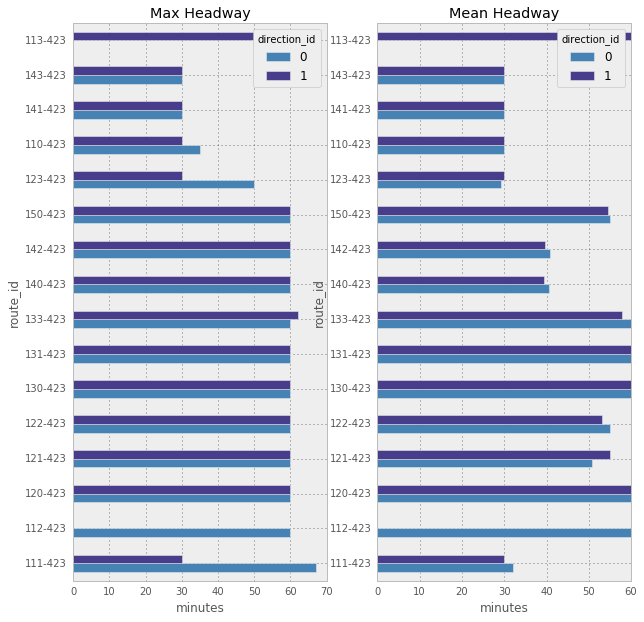

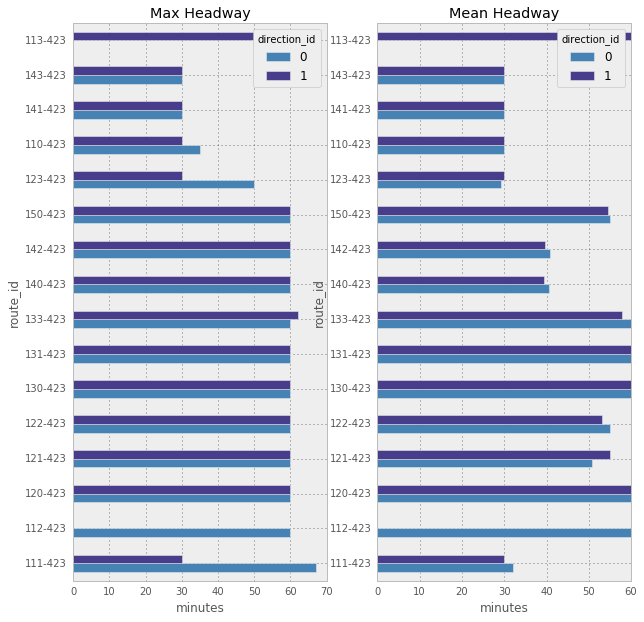

In [10]:
gt.plot_headways(routes_stats)

In [11]:
# Compute routes time series
rts = gt.compute_routes_time_series(feed, trips_stats, date, split_directions=True)
rts = gt.downsample(rts, freq='6H')
rts.head()

indicator           num_trip_starts                                      \
route_id                    110-423     110N-423    111-423     112-423   
direction_id                      0   1        0  1       0   1       0   
2014-05-30 00:00:00               1   0        4  5       0   0       0   
2014-05-30 06:00:00              12  10        0  0      12  10       5   
2014-05-30 12:00:00              12  12        0  0      12  12       6   
2014-05-30 18:00:00               5   7        0  0       5   7       4   

indicator                                 ...     service_speed             \
route_id            113-423    120-423    ...           142-423              
direction_id              0  1       0    ...                 0          1   
2014-05-30 00:00:00       0  0       1    ...               NaN        NaN   
2014-05-30 06:00:00       3  0       6    ...         25.915381  26.179643   
2014-05-30 12:00:00       0  2       6    ...         26.726927  26.179643   
2014-05-30 18:00:00       0  1       4    ...         26.726927  26.179643   

indicator                                                                  \
route_id               143-423              143W-423              150-423   
direction_id                 0          1          0         1          0   
2014-05-30 00:00:00        NaN        NaN        NaN       NaN        NaN   
2014-05-30 06:00:00  23.352055  25.496372        NaN       NaN  31.820862   
2014-05-30 12:00:00  23.352055  25.496372        NaN       NaN  31.820862   
2014-05-30 18:00:00  23.352055  25.496372  30.907527  29.87017  31.820862   

indicator                                             
route_id                         150E-423             
direction_id                 1          0          1  
2014-05-30 00:00:00        NaN        NaN        NaN  
2014-05-30 06:00:00  31.278634        NaN        NaN  
2014-05-30 12:00:00  31.278634        NaN        NaN  
2014-05-30 18:00:00  31.278634  33.833209  34.409551  

[4 rows x 200 columns]

In [12]:
fts = gt.compute_feed_time_series(feed, trips_stats, date, freq='1H')
gt.downsample(fts, freq='4H').head()


,num_trip_starts,service_distance,service_duration,num_trips,service_speed
2014-05-30 00:00:00,12,423.588152,8.850000,2.212500,47.863068
2014-05-30 04:00:00,81,1463.148646,49.183333,12.295833,29.748871
2014-05-30 08:00:00,164,3650.067131,128.216667,32.054167,28.467962
2014-05-30 12:00:00,162,3507.673152,123.350000,30.837500,28.436750
2014-05-30 16:00:00,149,3511.544548,119.900000,29.975000,29.287277


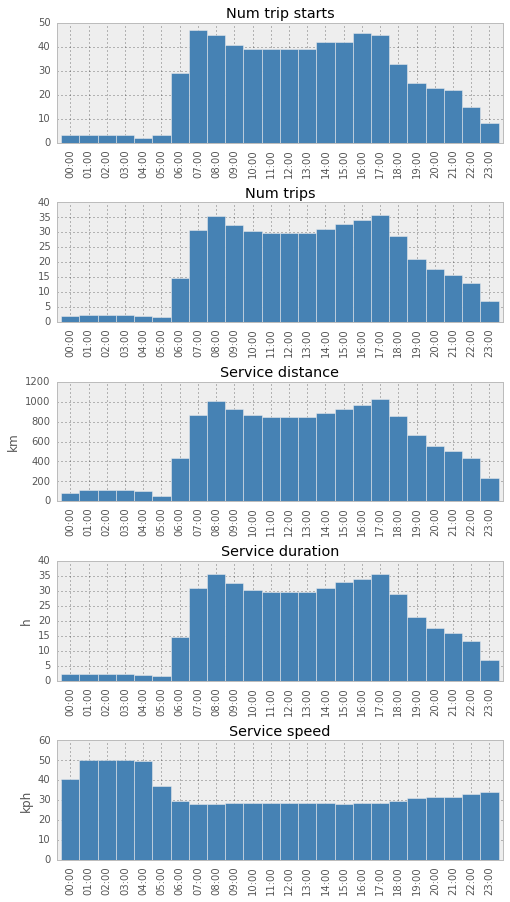

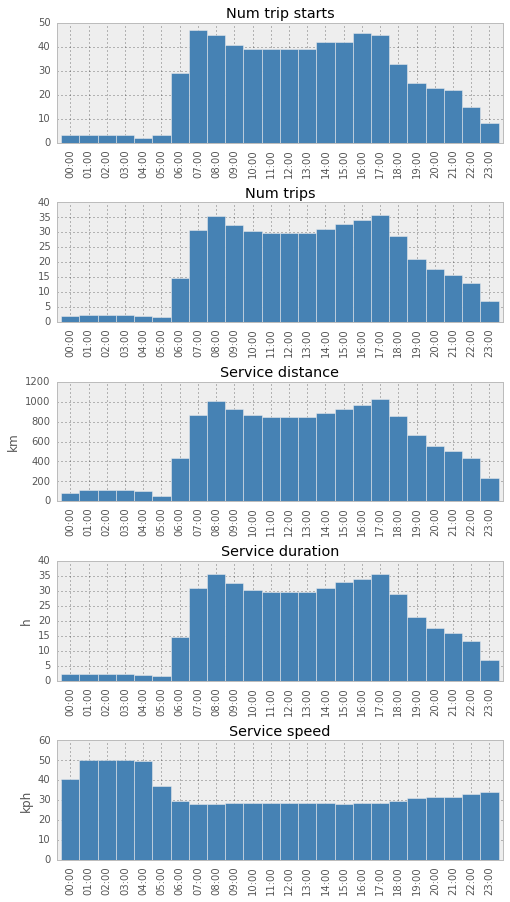

In [13]:
gt.plot_feed_time_series(fts)

In [14]:
# Get trip locations for every hour of the given date
rng = pd.date_range('1/1/2000', periods=24, freq='H')
times = [t.strftime('%H:%M:%S') for t in rng]
loc = gt.compute_trips_locations(feed, date, times)
loc.head()

,trip_id,rel_dist,time,route_id,direction_id,shape_id,lon,lat
0,CNS2014-CNS_MUL-Weekday-00-4165878,0.152945,06:00:00,110-423,0,1100023,145.669490,-16.762839
1,CNS2014-CNS_MUL-Weekday-00-4165879,0.720587,07:00:00,110-423,0,1100023,145.732413,-16.865060
2,CNS2014-CNS_MUL-Weekday-00-4165880,0.152945,07:00:00,110-423,0,1100023,145.669490,-16.762839
3,CNS2014-CNS_MUL-Weekday-00-4165881,0.720587,08:00:00,110-423,0,1100023,145.732413,-16.865060
4,CNS2014-CNS_MUL-Weekday-00-4165882,0.202283,08:00:00,110-423,0,1100023,145.675422,-16.768954


In [15]:
# Get a route timetable
route = feed.routes['route_id'].iat[0]
gt.get_route_timetable(feed, route, date).head().T

,0,1,2,3,4
route_id,110-423,110-423,110-423,110-423,110-423
service_id,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00
trip_id,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165878
trip_headsign,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus,The Pier Cairns Terminus
direction_id,0,0,0,0,0
block_id,NaN,NaN,NaN,NaN,NaN
shape_id,1100023,1100023,1100023,1100023,1100023
arrival_time,05:50:00,05:50:00,05:52:00,05:54:00,05:55:00
departure_time,05:50:00,05:50:00,05:52:00,05:54:00,05:55:00
stop_id,750337,750000,750001,750002,750003


In [16]:
# Get a stop time table
stop = feed.stops['stop_id'].iat[0]
gt.get_stop_timetable(feed, stop, date).head().T

,1,36,71,106,141
trip_id,CNS2014-CNS_MUL-Weekday-00-4165878,CNS2014-CNS_MUL-Weekday-00-4165879,CNS2014-CNS_MUL-Weekday-00-4165880,CNS2014-CNS_MUL-Weekday-00-4165881,CNS2014-CNS_MUL-Weekday-00-4165882
arrival_time,05:50:00,06:20:00,06:50:00,07:16:00,07:46:00
departure_time,05:50:00,06:20:00,06:50:00,07:16:00,07:46:00
stop_id,750000,750000,750000,750000,750000
stop_sequence,2,2,2,2,2
pickup_type,0,0,0,0,0
drop_off_type,0,0,0,0,0
shape_dist_traveled,0.46864,0.46864,0.46864,0.46864,0.46864
route_id,110-423,110-423,110-423,110-423,110-423
service_id,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00,CNS2014-CNS_MUL-Weekday-00
